# Forward Modeling of an Emission Spectrum using the MODIT Cross Section

Septempber 3rd (2021) Hajime Kawahara

We try to compute an emission spectrum in which many methane lines exist. This situation mocks a T-type brown dwarf.

In [1]:
from exojax.spec import rtransfer as rt
from exojax.spec import dit, modit

In [2]:
#ATMOSPHERE                                                                     
NP=100
T0=1295.0 #K
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = T0*(Parr)**0.1

A T-P profile we assume is here.

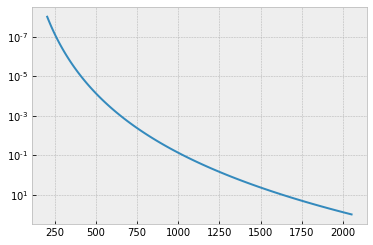

In [3]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.plot(Tarr,Parr)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.show()

We set a wavenumber grid using nugrid. Specify xsmode="modit" though it is not mandatory.
MODIT uses FFT, so the (internal) wavenumber grid should be evenly spaced in log. 

In [4]:
from exojax.spec.rtransfer import nugrid
nus,wav,R=nugrid(16360,16560,10000,unit="AA",xsmode="modit")

nugrid is log: mode= modit


Loading a molecular database of CH4 and CIA (H2-H2)... 

In [5]:
from exojax.spec import moldb, contdb
mdbCH4=moldb.MdbExomol('.database/CH4/12C-1H4/YT10to10/',nus,crit=1.e-30)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Note: Couldn't find the hdf5 format. We convert data to the hdf5 format. After the second time, it will become much faster.
Reading transition file
Note: Couldn't find the hdf5 format. We convert data to the hdf5 format. After the second time, it will become much faster.
Note: Couldn't find the hdf5 format. We convert data to the hdf5 format. After the second time, it will become much faster.
.broad is used.
Broadening code level= a1
default broadening parameters are used for  12  J lower states in  29  states
H2-H2


We have 140031 lines

In [6]:
len(mdbCH4.A)

140031

In [7]:
from exojax.spec import molinfo
molmassCH4=molinfo.molmass("CH4")

Computing the relative partition function, 

In [8]:
from jax import vmap
qt=vmap(mdbCH4.qr_interp)(Tarr)

Pressure and Natural broadenings 

In [9]:
from jax import jit
from exojax.spec.exomol import gamma_exomol
from exojax.spec import gamma_natural

gammaLMP = jit(vmap(gamma_exomol,(0,0,None,None)))\
        (Parr,Tarr,mdbCH4.n_Texp,mdbCH4.alpha_ref)
gammaLMN=gamma_natural(mdbCH4.A)
gammaLM=gammaLMP+gammaLMN[None,:]

And line strength

In [11]:
from exojax.spec import SijT
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr,mdbCH4.logsij0,mdbCH4.nu_lines,mdbCH4.elower,qt)

MODIT uses the normalized quantities by wavenumber/R, where R is the spectral resolution. In this case, the normalized Doppler width (nsigmaD) is common for the same isotope. Then, we use a 2D DIT grid with the normalized gammaL and q = R log(nu).

In [12]:
from exojax.spec import normalized_doppler_sigma
import numpy as np
nsigmaDl=normalized_doppler_sigma(Tarr,molmassCH4,R)[:,np.newaxis]

In [13]:
dv_lines=mdbCH4.nu_lines/R
ngammaLM=gammaLM/dv_lines

MODIT

In [14]:
dgm_ngammaL=modit.dgmatrix(ngammaLM,0.2)

2


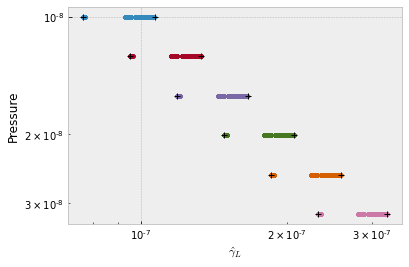

In [15]:
#show the DIT grids 
from exojax.plot.ditplot import plot_dgmn
plot_dgmn(Parr,dgm_ngammaL,ngammaLM,0,6)

In [15]:
from exojax.spec import initspec 
cnu,indexnu,R,pmarray=initspec.init_modit(mdbCH4.nu_lines,nus)

In [16]:
xsmmodit=modit.xsmatrix(cnu,indexnu,R,pmarray,nsigmaDl,ngammaLM,SijM,nus,dgm_ngammaL)

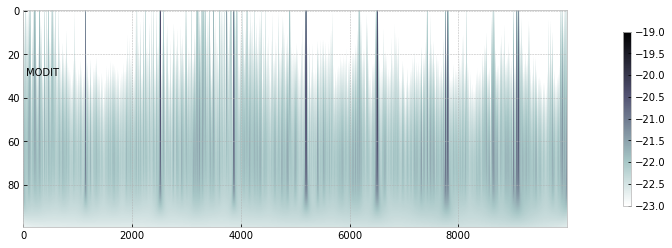

In [20]:
import numpy as np
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(111)
c=plt.imshow(np.log10(xsmmodit),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"MODIT")
ax.set_aspect(0.4/ax.get_data_ratio())
plt.show()

computing delta tau for CH4

In [21]:
from exojax.spec.rtransfer import dtauM
import jax.numpy as jnp
Rp=0.88
Mp=33.2
g=2478.57730044555*Mp/Rp**2
#g=1.e5 #gravity cm/s2
MMR=0.0059 #mass mixing ratio

# 0-padding for negative values
xsmnp=np.array(xsmmodit)
print(len(xsmnp[xsmnp<0.0]))
xsmnp[xsmnp<0.0]=0.0
xsmditc=jnp.array(xsmnp)
#-------------------------------

dtaum=dtauM(dParr,xsmditc,MMR*np.ones_like(Tarr),molmassCH4,g)

0


computing delta tau for CIA

In [22]:
from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

The total delta tau is a summation of them

In [23]:
dtau=dtaum+dtaucH2H2

you can plot a contribution function using exojax.plot.atmplot 

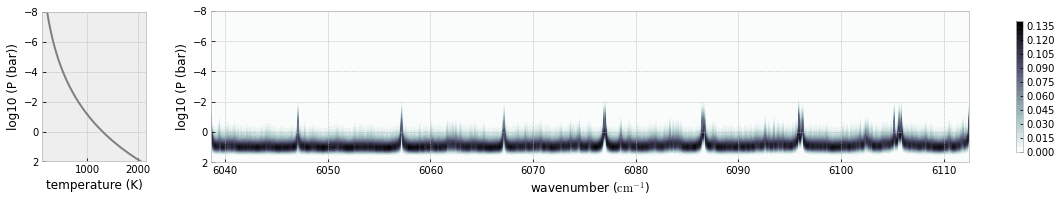

In [24]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()

radiative transfering...

In [25]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)

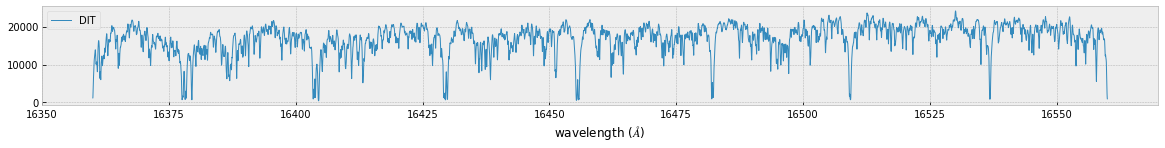

In [26]:
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(211)
plt.plot(wav[::-1],F0,lw=1,label="DIT")
plt.legend()
plt.xlabel("wavelength ($\AA$)")
plt.savefig("ch4.png")

MODIT uses ESLOG as the wavenunmber grid. We can directly apply the response to the raw spectrum.

In [27]:
from exojax.spec import response
from exojax.utils.constants import c
import jax.numpy as jnp

wavd=jnp.linspace(16360,16560,1500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

Rinst=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*Rinst) #IP sigma need check 

Frot=response.rigidrot(nus,F0,vsini,u1,u2)
F=response.ipgauss_sampling(nusd,nus,Frot,beta,RV)

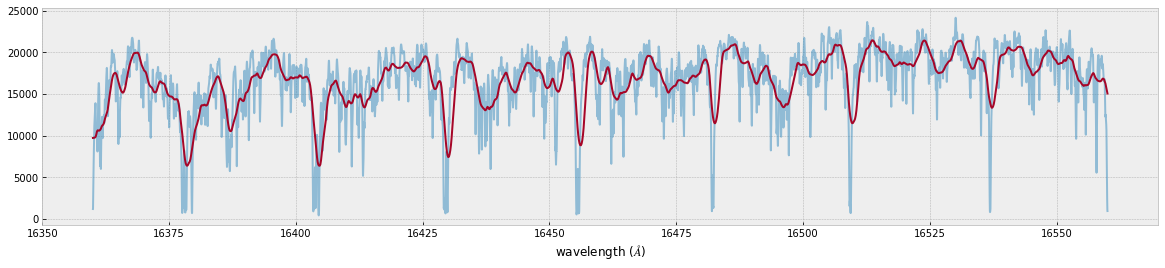

In [28]:
fig=plt.figure(figsize=(20,4))
plt.plot(wav[::-1],F0,alpha=0.5)
plt.plot(wavd[::-1],F)
plt.xlabel("wavelength ($\AA$)")
plt.savefig("moditCH4.png")

In [29]:
np.savetxt("spectrum_ch4.txt",np.array([wavd,F]).T,delimiter=",")